In [15]:
!pip install tensorflow numpy bing-image-downloader pillow matplotlib

  Using cached matplotlib-3.5.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached kiwisolver-1.4.2-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     |████████████████████████████████| 930 kB 1.5 MB/s eta 0:00:01


In [16]:
import tensorflow as tf
import numpy as np
import glob
from bing_image_downloader import downloader
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
CLASSES = [
	'macbook',
	'toilet',
	'hotdog',
	# 'equation',
	'keyboard',
	'phone',
	'pancake'
]
IMGS_PER_CLASS = 100
IMG_SHAPE = (224, 224)
TEST_SIZE = int((len(CLASSES) * IMGS_PER_CLASS)*.2)
BATCH_SIZE = 8

In [51]:
# Download data
for class_name in CLASSES:
	downloader.download(
		class_name,
		limit=IMGS_PER_CLASS,
		output_dir='dataset',
		adult_filter_off=False,
		force_replace=False,
		timeout=60,
		verbose=False
	)

[%] Downloading Images to /home/jankaifer/Projects/colabs/priroda/dataset/macbook
[!] Issue getting: https://appleinclusion.com/wp-content/uploads/2019/05/howard-lawrence-b-1141813-unsplash-1.jpg
[!] Error:: HTTP Error 404: Not Found
[!] Issue getting: https://external-preview.redd.it/5BCTe6GcIWnfl0RT6W9jsNIOeRoQ4K36oc24vpmzAeY.jpg?auto=webp&amp;s=2c9d35b3a5b39c78d0699d35c48e34a6214d2cb3
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: https://preview.redd.it/b0oy5ewj05e51.jpg?auto=webp&amp;s=be3cf283476f60f65b4b1d058c0441ddc2c93a21
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: https://preview.redd.it/1haehzc1gq351.jpg?auto=webp&amp;s=cd4c500e5f3014a18c704f478c121f54f72fe9a9
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: https://static.swappa.com/media/listing/LRHB24663/BqgLICvU.jpg
[!] Error:: HTTP Error 503: Service Temporarily Unavailable
[Error]Invalid image, not saving https://miro.medium.com/max/1200/1*nQqSw3LQHwOoKE3fv5Vr6g.jpeg

[!] Issue getting: h

In [72]:
def create_class_ds(path, class_name):
    def generator():
        for filename in glob.glob(f'{path}/*.*'):
            im = Image.open(filename).convert('RGBA')
            background = Image.new('RGBA', im.size, (255,255,255))
            im = Image.alpha_composite(background, im).convert('RGB')
            im = im.resize(IMG_SHAPE)
            yield np.array(im) / 255., CLASSES.index(class_name)
    
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(tf.TensorSpec(shape=(*IMG_SHAPE, 3), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.uint8)),
    )

class_datasets = [create_class_ds('dataset/' + class_name, class_name) for class_name in CLASSES]

ds = tf.data.Dataset.sample_from_datasets(class_datasets, seed=42).cache()

test_ds = ds.take(TEST_SIZE)
train_ds = ds.skip(TEST_SIZE)

In [73]:

def preview_ds(ds, rows=1, cols=15, figure_width=20):
  first_image = np.array(list(ds.take(1))[0][0])
  ratio = first_image.shape[0] / first_image.shape[1]
  line_height = figure_width / cols * ratio + .2
  figure_height = line_height * rows
  fig = plt.figure(figsize=(figure_width, figure_height))
  n = cols * rows
  
  # ax enables access to manipulate each of subplots
  ax = []

  for i, data in enumerate(ds.take(n)):
    img, label = [x.numpy() for x in data]
    # create subplot and append to ax
    ax.append(fig.add_subplot(rows, cols, i+1))
    ax[-1].set_title(CLASSES[label])
    plt.axis('off')
    plt.imshow(img)
  
  plt.show()
  

2022-04-25 21:08:41.513257: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-25 21:08:49.221414: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


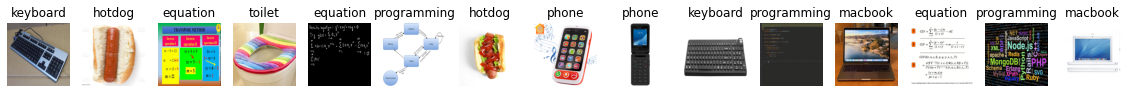

In [74]:
preview_ds(train_ds)

In [75]:
def train_and_benchmark_model(model, epochs=1):
	model.compile(
		optimizer='adam',
		loss='sparse_categorical_crossentropy',
		metrics=['accuracy']
	)
	
	model.fit(
		train_ds.batch(BATCH_SIZE),
		epochs=epochs,
		validation_data=test_ds.batch(BATCH_SIZE),
	)

In [76]:
def basic_model():
	model = tf.keras.Sequential([
		tf.keras.layers.Conv2D(32, 3, activation='relu'),
		tf.keras.layers.MaxPooling2D(),
		tf.keras.layers.Conv2D(64, 3, activation='relu'),
		tf.keras.layers.MaxPooling2D(),
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(64, activation='relu'),
		tf.keras.layers.Dense(len(CLASSES), activation='softmax')
	])
	return model

train_and_benchmark_model(model=basic_model())

82/82 [==============================] - 48s 502ms/step - loss: 1.9577 - accuracy: 0.3124 - val_loss: 2.6217 - val_accuracy: 0.2375


In [77]:
def eff_net_model():
	eff_net = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, pooling='max')
	model = tf.keras.Sequential([
		eff_net,
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(len(CLASSES), activation='softmax')
	])
	return model

train_and_benchmark_model(model=eff_net_model())

82/82 [==============================] - 47s 512ms/step - loss: 2.2977 - accuracy: 0.6095 - val_loss: 3.5041 - val_accuracy: 0.1250


In [78]:
def vgg_model():
	vgg = tf.keras.applications.vgg16.VGG16(include_top=False, pooling='max')
	model = tf.keras.Sequential([
		vgg,
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(len(CLASSES), activation='softmax')
	])
	return model

train_and_benchmark_model(model=vgg_model())

82/82 [==============================] - 174s 2s/step - loss: 2.2103 - accuracy: 0.1424 - val_loss: 3.1923 - val_accuracy: 0.1063


In [79]:
def mobile_net_model():
	mobile_net = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, pooling='max')
	model = tf.keras.Sequential([
		mobile_net,
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(len(CLASSES), activation='softmax')
	])
	return model

train_and_benchmark_model(model=mobile_net_model())

82/82 [==============================] - 30s 334ms/step - loss: 2.8730 - accuracy: 0.5881 - val_loss: 12.6288 - val_accuracy: 0.1688
